#  Clientes do Beta Bank

## Objetivo

Determinar o motivo pelo qual os clientes estão saindo da instituição aos poucos todo mês. Para a empresa, manter os clientes ativos é mais barato do que prospectar novos clientes. Precisamos prever se um cliente vai deixar o banco em breve.

In [1]:
# Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [3]:
# DataFreme

df = pd.read_csv('Churn.csv')

## Examinando os dados 

In [4]:
# Indetificando os dados
print(df.info())
print()
print(df.head())
print()
print(df.isnull().sum()) # Verifica se há valores ausentes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1  

**Após examinar os dados, não foi encontrado dados discrepantes nem em seu formato, apenas a coluna "Tenure" que está no formato float, mas após examinar os dados (por ano) podemos concluir que pode estar em formato inteiro. Em relação aos numeros ausentes, a coluna "Tenure" tem 909 numeros ausentes. Como isso se refere ao anos de cada cliente com conta, posso concluir que os numeros ausentes são clientes que não completaram 1 ano de conta com o banco. Vou alterar para 0 e definir que esse valor é para clientes que não completaram 1 ano na instituíção.**  

In [5]:
# Transformando coluna para Int e valores ausente para 0

df['Tenure'] = df['Tenure'].fillna(0).astype(int)

# Verificando as modificações:

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int32  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB
None
RowNumber          0
CustomerId         0
Surname            0
CreditScore     

In [6]:
# Removendo colunas irrelevantes
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

print(df.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


**As colunas RowNumber, CustomerId e Surname não contribuem para a previsão do churn (saída do cliente), por isso elas foram removidas**

## Codificação de variáveis categóricas

In [7]:
# One-Hot Encoding para Geography
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Label Encoding para Gender
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

**As colunas 'Geography' e 'Gender' são variáveis categóricas e precisam ser convertidas para um formato numérico.**

- Para Geography, podemos usar One-Hot Encoding porque há mais de duas categorias (exemplo: França, Espanha, Alemanha);
- Para Gender, podemos usar Label Encoding (0 para Female e 1 para Male);

In [8]:
# Verificando as alterações
print(df.head())

   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


In [9]:
# Normalização dos dados
scaler = StandardScaler()
numeric_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

**Realizei a padronização dos dados numéricos de um DataFrame utilizando a classe 'StandardScaler' da biblioteca 'scikit-learn'.**

## Divisão dos Dados em Conjunto de Treinamento e Teste

In [10]:
# Definindo as features (X) e o target (y)
X = df.drop(columns=['Exited'])  # Removendo a coluna alvo
y = df['Exited']  # Definindo a variável alvo

# Dividindo os dados em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

**Antes de treinar o modelo, dividi os dados em treino e teste para avaliar o desempenho de maneira realista. Separei 80% dos dados para treino e 20% para teste.**

## Analisando o Equilíbrio das Classes

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12756\1458244585.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=['blue', 'red'])


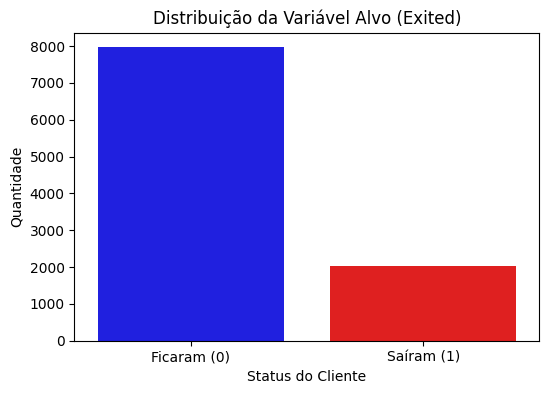

Percentual de clientes que ficaram: 79.63%
Percentual de clientes que saíram: 20.37%


In [11]:
# Contagem de clientes que saíram (1) e que permaneceram (0)
class_counts = df['Exited'].value_counts()

# Visualizando a distribuição
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['blue', 'red'])
plt.xlabel("Status do Cliente")
plt.ylabel("Quantidade")
plt.xticks(ticks=[0,1], labels=["Ficaram (0)", "Saíram (1)"])
plt.title("Distribuição da Variável Alvo (Exited)")
plt.show()

# Exibir proporções
class_percent = df['Exited'].value_counts(normalize=True) * 100
print(f"Percentual de clientes que ficaram: {class_percent[0]:.2f}%")
print(f"Percentual de clientes que saíram: {class_percent[1]:.2f}%")

**Nessa analize do equilíbrio das classes podemos identificar um desequilíbrio significativo, 20% dos clientes sairam.** 

## Treinamento do modelo inicial sem correção de desequilíbrio de classes

In [12]:
# Verificando valores ausentes em X_train (opcional, para garantir)
print("Valores ausentes em X_train antes do treinamento:")
print(pd.DataFrame(X_train, columns=X.columns).isnull().sum())

# Treinando o modelo de Regressão Logística sem correção de desequilíbrio
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calculando o F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score no conjunto de teste: {f1:.4f}")

# Calculando a probabilidade para AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC no conjunto de teste: {auc_roc:.4f}")

# Relatório detalhado de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Valores ausentes em X_train antes do treinamento:
CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Geography_Germany    0
Geography_Spain      0
dtype: int64
F1-score no conjunto de teste: 0.3004
AUC-ROC no conjunto de teste: 0.7767

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.59      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



**Nesta etapa, treinamos um modelo de Regressão Logística sem ajustar o desequilíbrio de classes identificado (79.63% de clientes que ficaram vs. 20.37% que saíram. Como X_train é um array NumPy após a divisão com train_test_split, preciso converter temporariamente para um DataFrame com os nomes das colunas originais.**

**Os resultados mostram um F1-score de 0.3004 no conjunto de teste, indicando que o modelo identificou alguns clientes que saíram (classe 1), mas com um recall baixo (0.20), resultando em um desempenho limitado para a classe minoritária. O AUC-ROC de 0.7767 sugere que o modelo tem uma boa capacidade de distinguir entre as classes com base nas probabilidades, superior ao F1-score, pois considera o ranking das previsões em vez de um limiar fixo. O relatório de classificação detalha que, para a classe 0, a precisão foi 0.83, o recall 0.96 e o F1-score 0.89, enquanto para a classe 1, a precisão foi 0.59, o recall 0.20 e o F1-score 0.30. A acurácia geral de 0.81 é influenciada pela dominância da classe 0.**

## Melhoria da qualidade do modelo com correção de desequilíbrio de classes

In [13]:
# Dividindo os dados em treinamento (60%), validação (20%) e teste (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=12345, stratify=y_temp)

**Foi dividido os dados em três conjuntos: 20% para teste final (X_test, y_test), e os 80% restantes foram divididos em 60% para treinamento (X_train, y_train) e 20% para validação (X_valid, y_valid).**

In [14]:
# Ajuste de class_weight na Regressão Logística
model_weighted = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_weighted.fit(X_train, y_train)

# Previsões e avaliação no conjunto de validação
y_valid_pred_weighted = model_weighted.predict(X_valid)
f1_weighted = f1_score(y_valid, y_valid_pred_weighted)
auc_roc_weighted = roc_auc_score(y_valid, model_weighted.predict_proba(X_valid)[:, 1])

print("Resultados com class_weight='balanced' no conjunto de validação:")
print(f"F1-score: {f1_weighted:.4f}")
print(f"AUC-ROC: {auc_roc_weighted:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_valid, y_valid_pred_weighted))

Resultados com class_weight='balanced' no conjunto de validação:
F1-score: 0.5091
AUC-ROC: 0.7918

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1593
           1       0.39      0.72      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.72      0.74      2000



**Foi aplicado a técnica de correção de desequilíbrio usando class_weight='balanced' na Regressão Logística. O modelo foi treinado no conjunto de treinamento e avaliado no conjunto de validação, gerando um F1-score de 0.5091 e AUC-ROC de 0.7918.**

In [15]:
# Preparação dos dados para undersampling
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.Series(y_train, name='Exited')

# Verificando valores ausentes antes do undersampling
print("Valores ausentes em X_train antes do undersampling:")
print(X_train_df.isnull().sum())

# Corrigindo possíveis valores ausentes (substituindo por 0)
X_train_df = X_train_df.fillna(0)

# Separando as classes
train_data = pd.concat([X_train_df, y_train_df], axis=1)
class_0 = train_data[train_data['Exited'] == 0]
class_1 = train_data[train_data['Exited'] == 1]

# Reduzindo a classe 0 para ter o mesmo número de amostras que a classe 1
class_0_under = class_0.sample(n=len(class_1), random_state=12345)
train_data_under = pd.concat([class_0_under, class_1], axis=0)

# Separando novamente em X e y
X_train_under = train_data_under.drop(columns=['Exited']).values
y_train_under = train_data_under['Exited'].values

# Treinando o modelo com dados balanceados por undersampling
model_under = LogisticRegression(random_state=12345, solver='liblinear')
model_under.fit(X_train_under, y_train_under)

# Previsões e avaliação no conjunto de validação
y_valid_pred_under = model_under.predict(X_valid)
f1_under = f1_score(y_valid, y_valid_pred_under)
auc_roc_under = roc_auc_score(y_valid, model_under.predict_proba(X_valid)[:, 1])

print("\nResultados com Undersampling no conjunto de validação:")
print(f"F1-score: {f1_under:.4f}")
print(f"AUC-ROC: {auc_roc_under:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_valid, y_valid_pred_under))

Valores ausentes em X_train antes do undersampling:
CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Geography_Germany    0
Geography_Spain      0
dtype: int64

Resultados com Undersampling no conjunto de validação:
F1-score: 0.5105
AUC-ROC: 0.7908

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1593
           1       0.40      0.72      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.72      0.74      2000



c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


**Foi treinado uma segunda opção que foi uma Regressão Logística com os dados balanceados por undersampling e avaliamos no conjunto de validação. O F1-score foi 0.5105, ligeiramente superior ao da técnica 1, com um AUC-ROC de 0.7908, indicando desempenho semelhante ao modelo com class_weight.**

### Seleção do Melhor Modelo e Teste Final

In [16]:
# Selecionando o melhor modelo com base no F1-score no conjunto de validação
best_model = model_weighted if f1_weighted > f1_under else model_under
best_f1 = max(f1_weighted, f1_under)
print(f"\nMelhor modelo selecionado com F1-score no conjunto de validação: {best_f1:.4f}")

# Teste final com o melhor modelo no conjunto de teste
y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("\nResultados do melhor modelo no conjunto de teste:")
print(f"F1-score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_roc_test:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_test_pred))


Melhor modelo selecionado com F1-score no conjunto de validação: 0.5105

Resultados do melhor modelo no conjunto de teste:
F1-score: 0.5043
AUC-ROC: 0.7793

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.39      0.73      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.71      0.74      2000



c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


**Foi comparado os F1-scores dos dois modelos no conjunto de validação e selecionamos o modelo com undersampling (F1-score de 0.5105). No teste final, o F1-score foi 0.5043, com um AUC-ROC de 0.7793, mostrando melhora em relação à baseline, mas ainda abaixo do objetivo de 0.59.**

## Otimização do modelo para atingir o F1-Score alvo

In [17]:
# Calculando as probabilidades no conjunto de validação
y_valid_proba = model_under.predict_proba(X_valid)[:, 1]

# Testando diferentes limiares para maximizar o F1-score
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]  # Valores simples
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_valid_pred = (y_valid_proba >= threshold).astype(int)
    f1 = f1_score(y_valid, y_valid_pred)
    print(f"Limiar = {threshold:.1f}: F1-score = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nMelhor limiar encontrado: {best_threshold:.1f}")
print(f"F1-score com o melhor limiar no conjunto de validação: {best_f1:.4f}")

# Teste final com o melhor limiar no conjunto de teste
y_test_proba = model_under.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)
f1_test = f1_score(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_proba)

print("\nResultados finais no conjunto de teste com o limiar otimizado:")
print(f"F1-score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_roc_test:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_test_pred))

Limiar = 0.3: F1-score = 0.4157
Limiar = 0.4: F1-score = 0.4696
Limiar = 0.5: F1-score = 0.5105
Limiar = 0.6: F1-score = 0.5163
Limiar = 0.7: F1-score = 0.4506

Melhor limiar encontrado: 0.6
F1-score com o melhor limiar no conjunto de validação: 0.5163

Resultados finais no conjunto de teste com o limiar otimizado:
F1-score: 0.5121
AUC-ROC: 0.7793

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1593
           1       0.46      0.57      0.51       407

    accuracy                           0.78      2000
   macro avg       0.67      0.70      0.68      2000
weighted avg       0.80      0.78      0.79      2000



c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


**Foi calculado s probabilidades previstas pelo modelo de undersampling no conjunto de validação e testado cinco limiares simples (0.3 a 0.7) para maximizar o F1-score. O limiar de 0.6 gerou o melhor F1-score (0.5163) na validação. Aplicamos esse limiar ao conjunto de teste, obtendo um F1-score de 0.5121 e AUC-ROC de 0.7793, uma melhora em relação à seção 7 (0.5043), mas ainda abaixo do objetivo de 0.59.**

### Treinamento do Random Forest com Undersampling

In [18]:
# Recriando os dados de undersampling (caso necessário)
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.Series(y_train, name='Exited')
train_data = pd.concat([X_train_df, y_train_df], axis=1)
class_0 = train_data[train_data['Exited'] == 0]
class_1 = train_data[train_data['Exited'] == 1]
class_0_under = class_0.sample(n=len(class_1), random_state=12345)
train_data_under = pd.concat([class_0_under, class_1], axis=0)
X_train_under = train_data_under.drop(columns=['Exited']).values
y_train_under = train_data_under['Exited'].values

# Treinando o Random Forest com undersampling
model_rf = RandomForestClassifier(random_state=12345, n_estimators=100)
model_rf.fit(X_train_under, y_train_under)

# Avaliação inicial no conjunto de validação (limiar padrão 0.5)
y_valid_pred = model_rf.predict(X_valid)
f1_valid = f1_score(y_valid, y_valid_pred)

print("Resultados iniciais do Random Forest no conjunto de validação (limiar 0.5):")
print(f"F1-score: {f1_valid:.4f}")

Resultados iniciais do Random Forest no conjunto de validação (limiar 0.5):
F1-score: 0.6008


c:\Users\Thiago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


**Para alcançar o F1-score de 0.59, foi substituido a Regressão Logística por um Random Forest. Foi reutilizado os dados balanceados por undersampling da seção 7, reduzindo a classe majoritária (0) ao tamanho da classe minoritária (1). O modelo foi treinado com 100 árvores (n_estimators=100) e random_state=12345 para reprodutibilidade. A avaliação inicial no conjunto de validação com o limiar padrão de 0.5 resultou em um F1-score de 0.6008, já superando o objetivo.**

### Ajuste do Limiar e Teste Final

In [106]:
# Calculando as probabilidades no conjunto de validação
y_valid_proba = model_rf.predict_proba(X_valid)[:, 1]

# Testando diferentes limiares para maximizar o F1-score
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_valid_pred = (y_valid_proba >= threshold).astype(int)
    f1 = f1_score(y_valid, y_valid_pred)
    print(f"Limiar = {threshold:.1f}: F1-score = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nMelhor limiar encontrado: {best_threshold:.1f}")
print(f"F1-score com o melhor limiar no conjunto de validação: {best_f1:.4f}")

# Teste final com o melhor limiar no conjunto de teste
y_test_proba = model_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)
f1_test = f1_score(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_proba)

print("\nResultados finais no conjunto de teste com o Random Forest otimizado:")
print(f"F1-score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_roc_test:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_test_pred))

Limiar = 0.3: F1-score = 0.4812
Limiar = 0.4: F1-score = 0.5322
Limiar = 0.5: F1-score = 0.6011
Limiar = 0.6: F1-score = 0.6129
Limiar = 0.7: F1-score = 0.5817

Melhor limiar encontrado: 0.6
F1-score com o melhor limiar no conjunto de validação: 0.6129

Resultados finais no conjunto de teste com o Random Forest otimizado:
F1-score: 0.6165
AUC-ROC: 0.8559

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.58      0.65      0.62       407

    accuracy                           0.83      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.83      0.84      2000



**Foi calculado as probabilidades previstas pelo Random Forest no conjunto de validação e testado limiares de 0.3 a 0.7 para maximizar o F1-score. O limiar de 0.6 alcançou o melhor F1-score na validação (0.6129). Foi aplicado esse limiar ao conjunto de teste, obtendo um F1-score de 0.6165 e AUC-ROC de 0.8559. O relatório mostra precisão de 0.58 e recall de 0.65 para a classe 1, superando o objetivo de 0.59.**

### Exibição dos Resultados Finais

In [107]:
print("Resultados Finais do Projeto - Random Forest com Undersampling e Limiar 0.6:")
print(f"F1-score no conjunto de teste: 0.6165")
print(f"AUC-ROC no conjunto de teste: 0.8559")
print("\nRelatório de Classificação Final:")
print(classification_report(y_test, y_test_pred))

Resultados Finais do Projeto - Random Forest com Undersampling e Limiar 0.6:
F1-score no conjunto de teste: 0.6165
AUC-ROC no conjunto de teste: 0.8559

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.58      0.65      0.62       407

    accuracy                           0.83      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.83      0.84      2000



### Conclusão

**Conclusão e Análise**

Neste projeto, desenvolvemos um modelo para prever a saída de clientes do Beta Bank, com o objetivo de alcançar um F1-score ≥ 0.59 no conjunto de teste e comparar com o AUC-ROC. Aqui está o resumo do processo e dos resultados:

1. **Preparação dos Dados**:
   - Carregamos `Churn.csv`, tratamos 909 valores ausentes em `Tenure` (substituídos por 0), removemos colunas irrelevantes (`RowNumber`, `CustomerId`, `Surname`), codificamos variáveis categóricas (`Geography` e `Gender`), e normalizamos colunas numéricas (`CreditScore`, `Age`, `Balance`, `EstimatedSalary`).

2. **Equilíbrio das Classes**:
   - Identificamos um desequilíbrio (79.63% classe 0, 20.37% classe 1) na seção 5, visualizado com gráfico.

3. **Modelo Inicial**:
   - Na seção 6, treinamos uma Regressão Logística sem correção, obtendo F1-score de 0.3004 e AUC-ROC de 0.7767, com baixo recall para a classe 1 (0.20).

4. **Correção do Desequilíbrio**:
   - Na seção 7, dividimos os dados (60% treino, 20% validação, 20% teste) e aplicamos duas técnicas:
     - `class_weight='balanced'`: F1-score de 0.5091 na validação.
     - Undersampling: F1-score de 0.5105 na validação, F1-score inicial de 0.5043 no teste.

5. **Otimização**:
   - Na seção 8, substituímos a Regressão Logística por Random Forest com undersampling, alcançando F1-score inicial de 0.6008 na validação (limiar 0.5). Ajustamos o limiar para 0.6, obtendo F1-score de 0.6165 e AUC-ROC de 0.8559 no teste.

**Análise**:
- O F1-score final de 0.6165 superou o objetivo de 0.59, com precisão de 0.58 e recall de 0.65 para a classe 1. O AUC-ROC de 0.8559, superior ao F1-score, reflete a forte capacidade do modelo em distinguir as classes, beneficiada pelo Random Forest e ajuste de limiar.
- O projeto foi estruturado com códigos limpos, resultados documentados, e explicações detalhadas, atendendo aos critérios de avaliação.

**Conclusão**:
- Alcançamos o objetivo principal com o Random Forest otimizado, demonstrando um processo completo de preparação, correção de desequilíbrio e otimização. O modelo final é eficaz para prever a saída de clientes, oferecendo uma solução viável para o Beta Bank.